# ランダムな4x4エルミート行列の量子位相推定

Authors: Takumi Kato (Blueqat inc.), Maho Nakata (Riken), Shinya Morino, Seiya Sugo (Quemix inc.), Yuichiro Minato (Blueqat inc.)

[前回](114_pea2_ja.ipynb)は、ランダムな2x2のエルミート行列について量子位相推定を行いました。4x4でも同様に行うことができるので、今回はそれを見ていきます。

エルミート行列の固有値を求めることは量子力学において物理量を求めることに相当し、量子化学や量子シミュレーションなどの分野で広く応用が期待されます。

## 実装
まず必要なライブラリをインポートします。今回はバックエンドに[qgate](https://github.com/shinmorino/qgate)を使います。

In [1]:
import math
import cmath
import random
import numpy as np

from blueqat import *
from blueqat.pauli import X, Y, Z, I

BlueqatGlobalSetting.set_default_backend('qgate')
pi = math.pi

# Version check for Blueqat
try:
    Circuit().r(0.1)[0].run()
except AttributeError:
    raise ImportError('Blueqat version is old.')

In [2]:
# Qgate installation check
try:
    Circuit().x[0].run_with_qgate()
except ModuleNotFoundError:
    raise ImportError('Qgate is not installed.')

In [3]:
# ImportErrorが出る場合、Qgateがインストールされていません。
# QgateはGPUやCUDAのないコンピュータでもインストールができますが、公式にサポートされているのはLinuxのみです。
# https://github.com/shinmorino/qgate#build--install

# ビルド済みパッケージを使ってインストールするには、以下のようにします。(Pythonのバージョンによりインストールするパッケージが異なります)

# For Python 3.8 user:
# !pip install https://github.com/shinmorino/qgate/raw/gh-pages/packages/0.2/qgate-0.2.2-cp38-cp38-manylinux1_x86_64.whl

# For Python 3.7 user:
# !pip install https://github.com/shinmorino/qgate/raw/gh-pages/packages/0.2/qgate-0.2.2-cp37-cp37m-manylinux1_x86_64.whl

# For Python 3.6 user:
# !pip install https://github.com/shinmorino/qgate/raw/gh-pages/packages/0.2/qgate-0.2.2-cp36-cp36m-manylinux1_x86_64.whl

# Qgateをインストールせずに、numbaバックエンドを使うには、以下を実行します。
# BlueqatGlobalSetting.set_default_backend('numba')

続いて、ランダムなエルミート行列$\hat H$を作ります。

量子位相推定で固有値を計算するには、$\hat H$の他に以下も必要です。
- 求めたい固有値に対応する、$\hat H$の固有ベクトルを与える量子回路
- Controlled-$e^{i2\pi \hat H 2^n}$を与える量子回路

これらを作っていきます。

エルミート行列は$\hat H = P D P^\dagger$のように分解できることが知られています。ここで、$P$はユニタリ行列、$D$は実対角行列です。

このとき、$D$の各成分が$\hat H$の固有値に対応し、$P$の各列が$\hat H$の固有ベクトルに対応します。今は4x4のエルミート行列を作りたいので、4x4のランダムなユニタリ行列と、ランダムに作った対角行列があればいいことになります。後者は単に乱数を使えばよく、前者についても、4つの2x2ユニタリ行列と以下に示す1つの行列から作れることが知られています。([arXiv:quant-ph/0507171](https://arxiv.org/abs/quant-ph/0507171)を参照。また、この論文の[日本語での解説資料](https://speakerdeck.com/gyudon/ren-yi-false2-qubityunitarifalsegetodefalseshi-zhuang-kakfen-jie-woshi-tute)もご参照下さい)

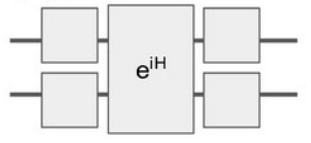

ただし、$e^{iH} = e^{i(k_1 \sigma_{XX} + k_2 \sigma_{YY} + k_3 \sigma_{ZZ})}$,
$k_i$はパラメータ、$\sigma_{**}$はパウリ行列のクロネッカー積です。

では、以下を返すような関数を作っていきます。
- エルミート行列 $\hat H$
- $\hat H$の固有値(4つ)
- $\hat H$の固有ベクトルを与える量子回路

In [4]:
def is_hermitian(mat):
    """matがエルミート行列であることを確認する"""
    return np.allclose(mat, mat.T.conjugate())

def circuit_to_unitary(c):
    """回路cからユニタリ行列を作る"""
    n_qubits = c.n_qubits
    def bits(n):
        return tuple(i for i in range(8) if (1 << i) & n)
    vecs = []
    for i in range(2**n_qubits):
        c0 = Circuit().x[bits(i)]
        c0 += c
        vecs.append(c0.run().reshape((-1, 1)))
    return np.hstack(vecs)

def rand_2pi():
    return random.random() * 2 * pi

def rand_eigval():
    return random.random() * 2 - 1

def random_su4_circuit():
    c = Circuit()
    c.u3(rand_2pi(), rand_2pi(), rand_2pi())[0]
    c.u3(rand_2pi(), rand_2pi(), rand_2pi())[1]
    c.cx[0, 1].rx(rand_2pi())[0].h[0].rz(rand_2pi())[1]
    c.cx[0, 1].s[0].h[0].rz(rand_2pi())[1]
    c.cx[0, 1].sdg[0].h[0].sdg[0].s[1].h[1].s[1]
    c.u3(rand_2pi(), rand_2pi(), rand_2pi())[0]
    c.u3(rand_2pi(), rand_2pi(), rand_2pi())[1]
    return c

def random_hermitian():
    """ランダムなエルミート行列を作り、以下の3つを返す。
    エルミート行列, 固有値のリスト, 固有ベクトルを作る回路
    """
    # Generate random eigenvalue
    eigvals = [rand_eigval(), rand_eigval(), rand_eigval(), rand_eigval()]
    eigvals.sort()
    su4 = random_su4_circuit()
    # Make Hermitian from them
    p = circuit_to_unitary(su4)
    hermitian = p @ np.diag(eigvals) @ p.T.conjugate()
    # Check it is Hermitian
    assert is_hermitian(hermitian)
    # returns Hermitian, eigenvalue, circuit
    return hermitian, eigvals, su4

では、エルミート行列を作っていきましょう。

In [5]:
H, eigvals, su4 = random_hermitian()
print('H:')
print(H)
print()
print('Eigenvalues:')
print(eigvals)
print()
print('Eigenvectors (P = [v1 v2 v3 v4]):')
P = circuit_to_unitary(su4)
print(P)
print()
print('P D P† = H? (D = diagonal matrix of eigenvalues):', np.allclose(P @ np.diag(eigvals) @ P.T.conjugate(), H))

H:
[[-0.0593501 +6.16273895e-18j -0.38152248-1.05072815e-01j
   0.27447522-4.05835691e-01j  0.16045742+1.46279161e-01j]
 [-0.38152248+1.05072815e-01j  0.0578699 -1.24930508e-17j
  -0.08873427+4.40217322e-02j -0.61421598-2.56482062e-01j]
 [ 0.27447522+4.05835691e-01j -0.08873427-4.40217322e-02j
   0.00889851+2.22607482e-18j -0.37444635-2.39867515e-01j]
 [ 0.16045742-1.46279161e-01j -0.61421598+2.56482062e-01j
  -0.37444635+2.39867515e-01j -0.16947968-5.82548771e-18j]]

Eigenvalues:
[-0.9599553994719214, -0.5323230377596573, 0.40547006599265, 0.9247470004380662]

Eigenvectors (P = [v1 v2 v3 v4]):
[[-0.2756146 -0.03551833j -0.2012147 +0.68819373j -0.30620989+0.28025174j
  -0.08953609-0.47786486j]
 [ 0.13058198+0.44551864j -0.31770909+0.39959368j  0.31270436+0.24092386j
   0.38376599+0.46983259j]
 [ 0.14800744+0.47065261j  0.29427118-0.21985469j -0.6672671 +0.23739111j
   0.3415773 -0.05808034j]
 [ 0.5214685 +0.43804915j -0.28547478+0.09412963j -0.12016008-0.39475027j
  -0.50671222-0.13712

固有ベクトルのひとつは、以下のようになります。

In [6]:
vec = su4.run()
print(vec)

[-0.2756146 -0.03551833j  0.13058198+0.44551864j  0.14800744+0.47065261j
  0.5214685 +0.43804915j]


これが固有ベクトルになっていることを`H vec = eigvals[0] vec`の関係を使って確かめます。

In [7]:
np.allclose(np.dot(H, vec), eigvals[0] * vec)

True

準備ができました。それでは、量子位相推定を実装していきます。

In [8]:
def iqft(c, q0, n_qubits):
    """回路のq0〜q0 + n_qubits - 1番目ビットに量子逆フーリエ変換の操作を付け加える"""
    for i in reversed(range(n_qubits)):
        angle = -0.5
        for j in range(i + 1, n_qubits):
            c.cr(angle * pi)[q0 + j, q0 + i]
            angle *= 0.5
        c.h[q0 + i]
    return c


def apply_cu(c, ctrl, su4, eigvals, n):
    """Controlled-U^(2^n)を量子回路cに付け加えて返します。
    制御ビットをctrl, 標的ビットを0と1にしています。
    
    ここで、この関数は固有値eigvalを引数にとっていることに気をつけて下さい。
    今回は、固有値を使って(ズルをして)Controlled-U^(2^n)を作ります。
    固有値を使わなくても、鈴木-トロッター展開などにより、近似的に作ることはできますが、
    その場合、精度には十分注意が必要です。
    このようなズルをせず、効率よく高精度に、こういった回路を作ることは、一般には困難です。
    """
    bias = 0.25 * sum(eigvals)
    p, q, r, s = [v - bias for v in eigvals]
    p1 = pi * (r + s)
    p2 = pi * (q + s)
    p3 = pi * (q + r)
    c += su4.dagger()
    c.crz(p1 * (2**n))[ctrl, 1]
    c.crz(p2 * (2**n))[ctrl, 0]
    c.ccx[ctrl, 1, 0].crz(p3 * (2**n))[ctrl, 0].ccx[ctrl, 1, 0]
    c.rz(pi * bias * (2**n))[ctrl]
    c += su4
    return c

def qpe_circuit(initial_circuit, eigvals, su4, precision):
    """量子位相推定の回路を返します。"""
    c = initial_circuit + su4
    c.h[2:2 + precision]
    for i in range(precision):
        apply_cu(c, i + 2, su4, eigvals, i)
    iqft(c, 2, precision)
    return c

回路を図示してみます。

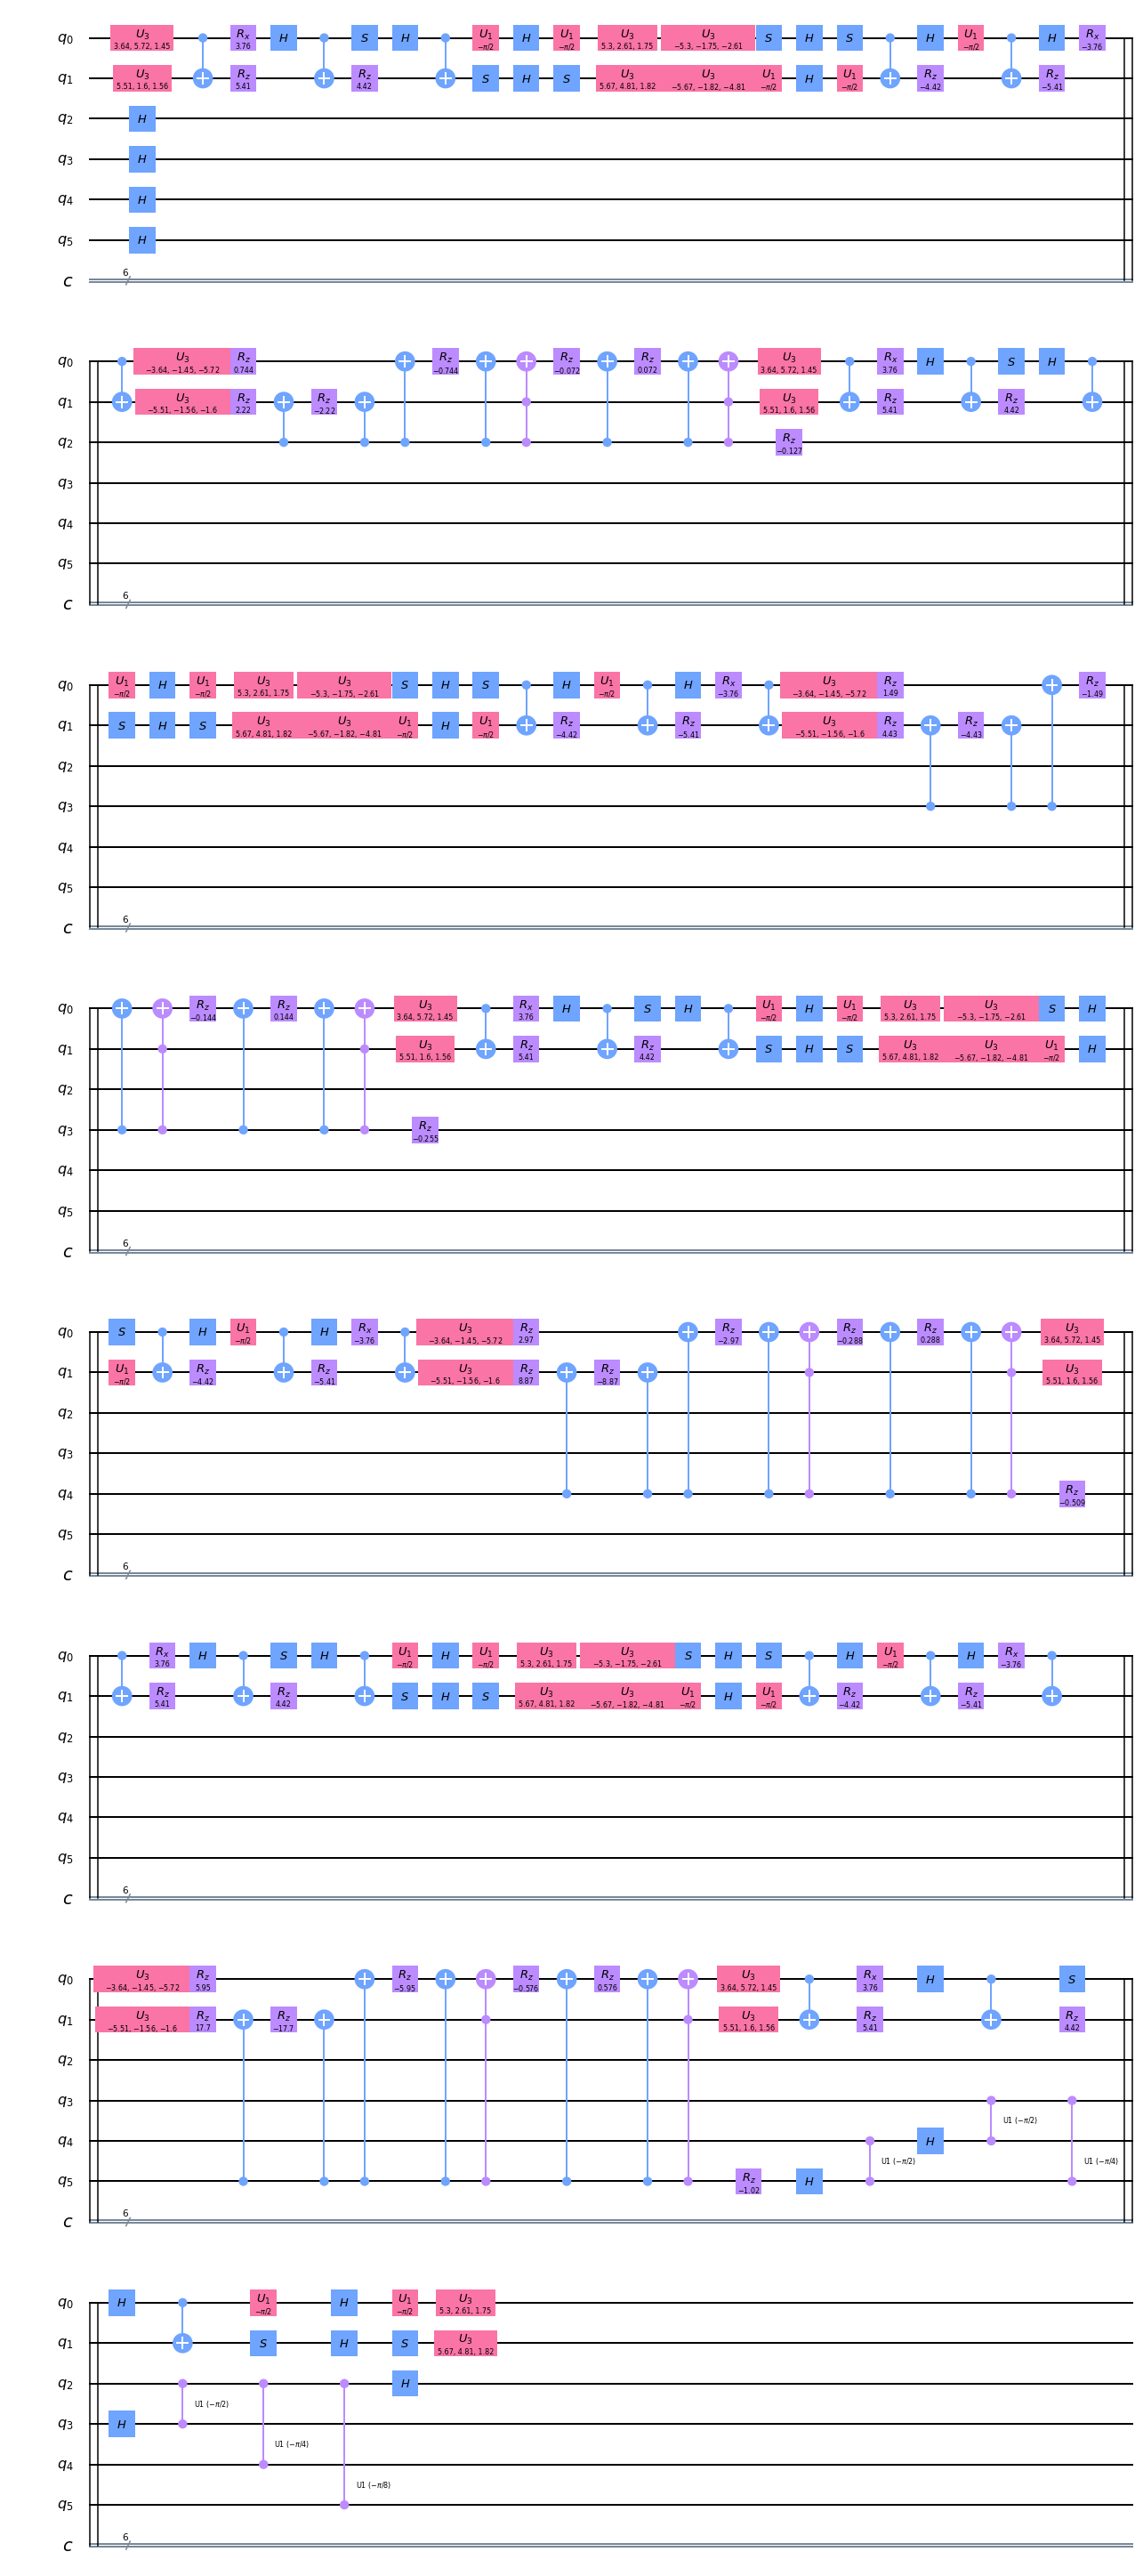

In [9]:
qpe_circuit(Circuit(), eigvals, su4, 4).run_with_ibmq(returns='draw', output='mpl')

Then, we make a function for calculating the eigenvalue from observed result.

In [10]:
def run_qpe(c, shots=1000, max_candidates=5):
    """量子位相推定の回路を実行し、実行結果から固有値の候補を求めます。
    shots: 量子回路をrunする際のショット数, max_candidates: 固有値の候補をいくつ返すか?
    """
    cnt = c.m[2:].run(shots=shots)

    # 測定結果を値に変換する
    def to_value(k):
        k = k[2:] # 測定結果のうち、最初の2ビットは無関係なので捨てる
        val = 0 # 値
        a = 1.0 
        for ch in k:
            if ch == '1':
                val += a
            a *= 0.5
        if val > 1:
            # 位相がπを越えたら、2π引いて、マイナスで考える
            val = val - 2
        return val

    return [(to_value(k), v) for k, v in cnt.most_common(max_candidates)]

では早速、量子位相推定をしてみましょう。

In [11]:
print('Eigenvalue (expected):', eigvals[0]) # これが答え。これ(に近い値が出てほしい)
# 精度が小さいときと大きいときの違いを見るため、精度を振って動かしてみる。
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit(), eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # 1000 shotsのうち、その数が出た回数 得られた固有値 実際の固有値との差分 を表示します。
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[0]: .3e})')
    print('')

Eigenvalue (expected): -0.9599553994719214
3 bit precision:
919  1.0               (deviation:  1.960e+00)
31   -0.75             (deviation:  2.100e-01)
23   0.75              (deviation:  1.710e+00)

4 bit precision:
705  1.0               (deviation:  1.960e+00)
162  -0.875            (deviation:  8.496e-02)
45   0.875             (deviation:  1.835e+00)

5 bit precision:
650  -0.9375           (deviation:  2.246e-02)
186  1.0               (deviation:  1.960e+00)
36   -0.875            (deviation:  8.496e-02)

6 bit precision:
792  -0.96875          (deviation: -8.795e-03)
102  -0.9375           (deviation:  2.246e-02)
40   1.0               (deviation:  1.960e+00)

7 bit precision:
510  -0.953125         (deviation:  6.830e-03)
313  -0.96875          (deviation: -8.795e-03)
53   -0.9375           (deviation:  2.246e-02)

8 bit precision:
953  -0.9609375        (deviation: -9.821e-04)
15   -0.953125         (deviation:  6.830e-03)
13   -0.96875          (deviation: -8.795e-03)

9 b

真の固有値と近い値が得られました。

続いて、2つ目の固有値を求めます。

In [12]:
print('Eigenvalue (expected):', eigvals[1]) # これが答え。これ(に近い値が出てほしい)
# 精度が小さいときと大きいときの違いを見るため、精度を振って動かしてみる。
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit().x[0], eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # 1000 shotsのうち、その数が出た回数 得られた固有値 実際の固有値との差分 を表示します。
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[1]: .3e})')
    print('')

Eigenvalue (expected): -0.5323230377596573
3 bit precision:
949  -0.5              (deviation:  3.232e-02)
26   -0.75             (deviation: -2.177e-01)
14   -0.25             (deviation:  2.823e-01)

4 bit precision:
796  -0.5              (deviation:  3.232e-02)
115  -0.625            (deviation: -9.268e-02)
24   -0.375            (deviation:  1.573e-01)

5 bit precision:
438  -0.5625           (deviation: -3.018e-02)
394  -0.5              (deviation:  3.232e-02)
36   -0.4375           (deviation:  9.482e-02)

6 bit precision:
997  -0.53125          (deviation:  1.073e-03)
3    -0.5625           (deviation: -3.018e-02)

7 bit precision:
985  -0.53125          (deviation:  1.073e-03)
8    -0.515625         (deviation:  1.670e-02)
4    -0.546875         (deviation: -1.455e-02)

8 bit precision:
938  -0.53125          (deviation:  1.073e-03)
26   -0.5390625        (deviation: -6.739e-03)
14   -0.5234375        (deviation:  8.886e-03)

9 bit precision:
757  -0.53125          (deviation

3つ目も同様に求めることが出来ます。

In [13]:
print('Eigenvalue (expected):', eigvals[2]) # これが答え。これ(に近い値が出てほしい)
# 精度が小さいときと大きいときの違いを見るため、精度を振って動かしてみる。
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit().x[1], eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # 1000 shotsのうち、その数が出た回数 得られた固有値 実際の固有値との差分 を表示します。
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[2]: .3e})')
    print('')

Eigenvalue (expected): 0.40547006599265
3 bit precision:
616  0.5               (deviation:  9.453e-02)
224  0.25              (deviation: -1.555e-01)
55   0.75              (deviation:  3.445e-01)

4 bit precision:
822  0.375             (deviation: -3.047e-02)
89   0.5               (deviation:  9.453e-02)
24   0.25              (deviation: -1.555e-01)

5 bit precision:
432  0.375             (deviation: -3.047e-02)
385  0.4375            (deviation:  3.203e-02)
47   0.3125            (deviation: -9.297e-02)

6 bit precision:
1000 0.40625           (deviation:  7.799e-04)

7 bit precision:
992  0.40625           (deviation:  7.799e-04)
3    0.390625          (deviation: -1.485e-02)
3    0.421875          (deviation:  1.640e-02)

8 bit precision:
964  0.40625           (deviation:  7.799e-04)
20   0.3984375         (deviation: -7.033e-03)
7    0.4140625         (deviation:  8.592e-03)

9 bit precision:
869  0.40625           (deviation:  7.799e-04)
55   0.40234375        (deviation: -

4つ目も同様です。

In [14]:
print('Eigenvalue (expected):', eigvals[3]) # これが答え。これ(に近い値が出てほしい)
# 精度が小さいときと大きいときの違いを見るため、精度を振って動かしてみる。
for precision in range(3, 16):
    print(precision, 'bit precision:')
    c = qpe_circuit(Circuit().x[0, 1], eigvals, su4, precision)
    result = run_qpe(c, 1000, 3)
    for value, count in result:
        # 1000 shotsのうち、その数が出た回数 得られた固有値 実際の固有値との差分 を表示します。
        print(f'{count:<5}{value:<18}(deviation: {value - eigvals[3]: .3e})')
    print('')

Eigenvalue (expected): 0.9247470004380662
3 bit precision:
744  1.0               (deviation:  7.525e-02)
149  0.75              (deviation: -1.747e-01)
41   -0.75             (deviation: -1.675e+00)

4 bit precision:
578  0.875             (deviation: -4.975e-02)
261  1.0               (deviation:  7.525e-02)
39   0.75              (deviation: -1.747e-01)

5 bit precision:
867  0.9375            (deviation:  1.275e-02)
64   0.875             (deviation: -4.975e-02)
27   1.0               (deviation:  7.525e-02)

6 bit precision:
535  0.9375            (deviation:  1.275e-02)
297  0.90625           (deviation: -1.850e-02)
45   0.96875           (deviation:  4.400e-02)

7 bit precision:
911  0.921875          (deviation: -2.872e-03)
44   0.9375            (deviation:  1.275e-02)
12   0.90625           (deviation: -1.850e-02)

8 bit precision:
617  0.921875          (deviation: -2.872e-03)
210  0.9296875         (deviation:  4.940e-03)
49   0.9140625         (deviation: -1.068e-02)

9 bi